In [1]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
import numpy as np 
import pandas as pd 

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Predictive Maintenance of the Air Production Unit from a MetroPT3 locomotive 

Data Set Information:
The dataset was collected to support the development of predictive maintenance, anomaly detection, and remaining
useful life (RUL) prediction models for compressors using deep learning and machine learning methods.
It consists of multivariate time series data obtained from several analogue and digital sensors installed on the
compressor of a train. The data span between February and August 2020 and includes 15 signals, such as pressures,
motor current, oil temperature, and electrical signals of air intake valves. The monitoring and logging of industrial
equipment events, such as temporal behaviour and fault events, were obtained from records generated by the
sensors. The data were logged at 1Hz by an onboard embedded device. You can find a schematic diagram of the air
production unit of the compressor system in Figure 4 of the accompanying paper [1]. Also, the paper [2] provides a
detailed examination of data collection and specifications of various types of potential failures in an air compressor
system

Attribute Information:
The dataset consists of 15169480 data points collected at 1Hz  from February to August 2020 and is described by 15 features from 7 analogue (1-7) and 8 digital (8-15) sensors:
1. TP2 (bar) – the measure of the pressure on the compressor.
2. TP3 (bar) – the measure of the pressure generated at the pneumatic panel.
3. H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.
4. DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.
5. Reservoirs (bar) – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).
6. Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.
7. Oil Temperature (ºC) –  the measure of the oil temperature on the compressor.
8. COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.
9. DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.
10. TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.
11. MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.
12. LPS – the electrical signal that detects and activates when the pressure drops below 7 bars.
13. Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.
14. Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.
15. Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.

Relevant Papers:
[1]- Davari, N., Veloso, B., Ribeiro, R.P., Pereira, P.M., Gama, J.: Predictive maintenance based on anomaly
detection using deep learning for air production unit in the railway industry. In: 2021 IEEE 8th International
Conference on Data Science and Advanced Analytics (DSAA). pp. 1–10. IEEE (2021) (DOI:
10.1109/DSAA53316.2021.9564181)
 
[2] Veloso, B., Ribeiro, R.P., Pereira, P.M., Gama, J.: The MetroPT dataset for predictive maintenance. Scientific
Data 9, no. 1 (2022): 764. (DOI: 10.1038/s41597-022-01877-3)

[3]-Barros, M., Veloso, B., Pereira, P.M., Ribeiro, R.P., Gama, J.: Failure detection of an air production unit in the
operational context. In: IoT Streams for Data-Driven Predictive Maintenance and IoT, Edge, and Mobile for
Embedded Machine Learning, pp. 61–74. Springer (2020) (DOI: 10.1007/978-3-030-66770-2_5)

Source:
Narjes Davari, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, narjes.davari@inesctec.pt
Bruno Veloso, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Economics,
University of Porto, Portugal bveloso@fep.up.pt
Rita P. Ribeiro, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Sciences,
University of Porto, Portugal. rpribeiro@fc.up.pt
Joao Gama, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Economics,
University of Porto, Portugal. jgama@fep.up.pt

In [2]:
# Reading in MetroPT3 Air Compressor data

n = 10  # e.g. every 100th line = 1% of the lines
metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', header=0, index_col =[1], skiprows=lambda i: i % n != 0)

#metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', nrows=800000)
metro_df_large.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,,
2020-02-01 00:01:29,90,-0.012,9.264,9.248,-0.022,9.264,53.375,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:03:08,190,-0.012,9.162,9.146,-0.024,9.164,53.325,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:04:47,290,-0.014,9.060,9.044,-0.022,9.062,53.125,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:06:26,390,-0.012,8.960,8.946,-0.024,8.962,52.900,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:08:06,490,-0.014,8.862,8.850,-0.024,8.866,52.650,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


Failure Information:

The dataset is unlabeled, but the failure reports provided by the company are available in the following table. This allows for evaluating the effectiveness of anomaly detection, failure prediction, and RUL estimation algorithms.

  Nr.     Start Time	          End Time	                 Failure	      Severity	         Report
* #1 	4/18/2020 0:00	   4/18/2020 23:59       Air leak	    High stress	
* #1 	5/29/2020 23:30     5/30/2020 6:00	    Air Leak	    High stress	Maintenance on 30Apr at 12:00
* #3 	6/5/2020 10:00	   6/7/2020 14:30	        Air Leak	    High stress	Maintenance on 8Jun at 16:00
* #4 	7/15/2020 14:30     7/15/2020 19:00      Air Leak	    High stress	Maintenance on 16Jul at 00:00

In [3]:
metro_df_large.shape

(151694, 16)

In [4]:
metro_df_large = metro_df_large.rename(columns={'DV_eletric':'DV_electric'})

# Exploratory Data Analysis

In [5]:
# Summary statistics of the numeric features
metro_df_large.describe()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,1.516940e+05,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.00000,151694.000000
mean,7.584740e+06,1.366243,8.984674,7.571054,0.056117,8.985295,62.645369,2.047747,0.837100,0.160079,0.919997,0.832821,0.003435,0.990988,0.90382,0.936754
std,4.379043e+06,3.249054,0.639051,3.330484,0.382425,0.638263,6.513671,2.301477,0.369276,0.366680,0.271299,0.373137,0.058504,0.094501,0.29484,0.243405
min,9.000000e+01,-0.032000,0.894000,-0.032000,-0.032000,0.876000,17.750000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,3.792415e+06,-0.014000,8.494000,8.254000,-0.022000,8.494000,57.775000,0.040000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000
50%,7.584740e+06,-0.012000,8.960000,8.786000,-0.020000,8.960000,62.725000,0.045000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000
75%,1.137706e+07,-0.010000,9.490000,9.374000,-0.018000,9.490000,67.250000,3.807500,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.00000,1.000000
max,1.516939e+07,10.614000,10.262000,10.262000,7.236000,10.266000,88.950000,8.847500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [6]:
# Examining null count and data types of features
metro_df_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151694 entries, 2020-02-01 00:01:29 to 2020-09-01 03:58:31
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       151694 non-null  int64  
 1   TP2              151694 non-null  float64
 2   TP3              151694 non-null  float64
 3   H1               151694 non-null  float64
 4   DV_pressure      151694 non-null  float64
 5   Reservoirs       151694 non-null  float64
 6   Oil_temperature  151694 non-null  float64
 7   Motor_current    151694 non-null  float64
 8   COMP             151694 non-null  float64
 9   DV_electric      151694 non-null  float64
 10  Towers           151694 non-null  float64
 11  MPG              151694 non-null  float64
 12  LPS              151694 non-null  float64
 13  Pressure_switch  151694 non-null  float64
 14  Oil_level        151694 non-null  float64
 15  Caudal_impulses  151694 non-null  float64
dtypes: float64(1

In [7]:
metro_df_large.index.dtype

dtype('O')

In [8]:
# Converting index to datetime datatype
metro_df_large.index = pd.to_datetime(metro_df_large.index) 

# Removing rows that occur during failed period to create a dataframe of metrics during normal operation
normal_op_df = metro_df_large.loc[((metro_df_large.index < '04-18-2020 00:00:00') | (metro_df_large.index >'04-18-2020 23:59:00')) & 
                  ((metro_df_large.index < '05-29-2020 23:30:00') | (metro_df_large.index >'05-30-2020 06:00:00')) &
                  ((metro_df_large.index < '06-05-2020 10:00:00') | (metro_df_large.index >'06-07-2020 14:30:00')) &
                  ((metro_df_large.index < '07-15-2020 14:30:00') | (metro_df_large.index >'07-15-2020 19:00:00'))]

# Creating a target feature

The valuable information of the actual machinery failures needs to be transformed into a feature in the dataframe. Here I take steps to create failure_start, failure_end, and failure_duration features. I will use these to test the performance of the classification model.

In [9]:
# Creating a dataframe of failure data from the provided failure table

dt_fail_starts = pd.to_datetime(['2020-04-18 00:00','2020-05-29 23:30','2020-06-05 10:00','2020-07-15 14:30'])
dt_fail_ends = pd.to_datetime(['04/18/2020 23:59', '05/30/2020 6:00', '06/07/2020 14:30', '07/15/2020 19:00'])

fail_ranges_week = [pd.date_range(start=(fail_start - pd.Timedelta(days=7)), end=fail_start) for fail_start in dt_fail_starts]
fail_ranges_day = [pd.date_range(start=(fail_start - pd.Timedelta(days=1)), end=fail_start) for fail_start in dt_fail_starts]
fail_ranges_hour = [pd.date_range(start=(fail_start - pd.Timedelta(hours=1)), end=fail_start) for fail_start in dt_fail_starts]

failure_df = pd.DataFrame(list(zip(fail_ranges_week, fail_ranges_day, fail_ranges_hour, dt_fail_starts, dt_fail_ends)), columns=['pre_fail_week','pre_fail_day','pre_fail_hour','failure_start','failure_end'])
failure_df.set_index('pre_fail_week')
failure_df.dtypes

pre_fail_week            object
pre_fail_day             object
pre_fail_hour            object
failure_start    datetime64[ns]
failure_end      datetime64[ns]
dtype: object

In [10]:
failure_df['pre_fail_day'].explode()

0   2020-04-17 00:00:00
0   2020-04-18 00:00:00
1   2020-05-28 23:30:00
1   2020-05-29 23:30:00
2   2020-06-04 10:00:00
2   2020-06-05 10:00:00
3   2020-07-14 14:30:00
3   2020-07-15 14:30:00
Name: pre_fail_day, dtype: datetime64[ns]

In [11]:
failure_df = failure_df.explode('pre_fail_week')

failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,2020-04-11 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-13 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-14 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-15 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-16 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-17 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-18 00:00:00,"DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
1,2020-05-22 23:30:00,"DatetimeIndex(['2020-05-28 23:30:00', '2020-05...","DatetimeIndex(['2020-05-29 22:30:00'], dtype='...",2020-05-29 23:30:00,2020-05-30 06:00:00
1,2020-05-23 23:30:00,"DatetimeIndex(['2020-05-28 23:30:00', '2020-05...","DatetimeIndex(['2020-05-29 22:30:00'], dtype='...",2020-05-29 23:30:00,2020-05-30 06:00:00


In [12]:
failure_df = failure_df.explode('pre_fail_day')
failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,2020-04-11 00:00:00,2020-04-17 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-11 00:00:00,2020-04-18 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-17 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-18 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-13 00:00:00,2020-04-17 00:00:00,"DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
...,...,...,...,...,...
3,2020-07-13 14:30:00,2020-07-15 14:30:00,"DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-14 14:30:00,"DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-15 14:30:00,"DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-15 14:30:00,2020-07-14 14:30:00,"DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00


In [13]:
failure_df.pre_fail_day.value_counts()

2020-04-17 00:00:00    8
2020-04-18 00:00:00    8
2020-05-28 23:30:00    8
2020-05-29 23:30:00    8
2020-06-04 10:00:00    8
2020-06-05 10:00:00    8
2020-07-14 14:30:00    8
2020-07-15 14:30:00    8
Name: pre_fail_day, dtype: int64

In [14]:
failure_df = failure_df.explode('pre_fail_hour')
failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,2020-04-11 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-11 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-13 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
...,...,...,...,...,...
3,2020-07-13 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-15 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00


In [15]:
failure_df.pre_fail_hour.value_counts()

2020-04-17 23:00:00    16
2020-05-29 22:30:00    16
2020-06-05 09:00:00    16
2020-07-15 13:30:00    16
Name: pre_fail_hour, dtype: int64

In [16]:
# Creating a fail_duration feature by subtracting datetime objects, returning a timedelta

failure_df['fail_duration'] = failure_df['failure_end'] - failure_df['failure_start'] 
failure_df['fail_date'] = failure_df['failure_start'].dt.date
failure_df = failure_df.set_index('pre_fail_week').sort_index()

print(failure_df.head())
print(failure_df.dtypes)

              pre_fail_day       pre_fail_hour failure_start  \
pre_fail_week                                                  
2020-04-11      2020-04-17 2020-04-17 23:00:00    2020-04-18   
2020-04-11      2020-04-18 2020-04-17 23:00:00    2020-04-18   
2020-04-12      2020-04-17 2020-04-17 23:00:00    2020-04-18   
2020-04-12      2020-04-18 2020-04-17 23:00:00    2020-04-18   
2020-04-13      2020-04-17 2020-04-17 23:00:00    2020-04-18   

                      failure_end   fail_duration   fail_date  
pre_fail_week                                                  
2020-04-11    2020-04-18 23:59:00 0 days 23:59:00  2020-04-18  
2020-04-11    2020-04-18 23:59:00 0 days 23:59:00  2020-04-18  
2020-04-12    2020-04-18 23:59:00 0 days 23:59:00  2020-04-18  
2020-04-12    2020-04-18 23:59:00 0 days 23:59:00  2020-04-18  
2020-04-13    2020-04-18 23:59:00 0 days 23:59:00  2020-04-18  
pre_fail_day      datetime64[ns]
pre_fail_hour     datetime64[ns]
failure_start     datetime64[ns]
fail

In [17]:
failure_df.fail_duration.value_counts()

0 days 23:59:00    16
0 days 06:30:00    16
2 days 04:30:00    16
0 days 04:30:00    16
Name: fail_duration, dtype: int64

In [18]:
metro_df_large.index = pd.to_datetime(metro_df_large.index)

In [19]:
tol = pd.Timedelta(metro_df_large.index[1] - metro_df_large.index[0])
#tol = pd.Timedelta('10 minutes')

merged_df = pd.merge_asof(left = metro_df_large,right = failure_df, left_index= True, right_index=True, direction='nearest', tolerance=tol).drop(columns='Unnamed: 0', axis=1)
merged_df

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,...,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_day,pre_fail_hour,failure_start,failure_end,fail_duration,fail_date
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:01:29,-0.012,9.264,9.248,-0.022,9.264,53.375,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-02-01 00:03:08,-0.012,9.162,9.146,-0.024,9.164,53.325,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-02-01 00:04:47,-0.014,9.060,9.044,-0.022,9.062,53.125,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-02-01 00:06:26,-0.012,8.960,8.946,-0.024,8.962,52.900,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-02-01 00:08:06,-0.014,8.862,8.850,-0.024,8.866,52.650,0.0400,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-01 03:51:54,-0.012,9.572,9.558,-0.022,9.574,64.525,3.8825,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-09-01 03:53:33,-0.012,9.418,9.408,-0.022,9.420,64.750,3.8100,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN
2020-09-01 03:55:12,-0.012,9.270,9.258,-0.020,9.270,63.175,0.0450,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,NaT,NaT,NaT,NaT,NaT,NaN


In [20]:
merged_df.pre_fail_hour.value_counts()

2020-06-05 09:00:00    15
2020-04-17 23:00:00    13
2020-07-15 13:30:00    10
2020-05-29 22:30:00     9
Name: pre_fail_hour, dtype: int64

In [21]:
hour_pre_fail_df = merged_df.loc[merged_df['pre_fail_hour'].notnull()]

hour_pre_fail_df.describe()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,fail_duration
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.0,47.0,47.0,47.0,47
mean,2.358170,8.874340,6.338255,0.151191,8.875191,65.270745,2.244468,0.702128,0.297872,0.829787,0.702128,0.0,1.0,1.0,1.0,1 days 01:35:28.085106382
std,4.048373,0.631253,3.996084,0.538737,0.629936,7.075521,2.571894,0.462267,0.462267,0.379883,0.462267,0.0,0.0,0.0,0.0,0 days 20:07:15.988492338
min,-0.018000,8.066000,-0.028000,-0.024000,8.068000,49.450000,0.037500,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,1.0,0 days 04:30:00
25%,-0.013000,8.248000,0.038000,-0.022000,8.248000,60.475000,0.040000,0.000000,0.000000,1.000000,0.000000,0.0,1.0,1.0,1.0,0 days 06:30:00
50%,-0.010000,8.782000,8.238000,-0.018000,8.784000,65.175000,0.042500,1.000000,0.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,0 days 23:59:00
75%,4.285000,9.495000,8.988000,-0.014000,9.495000,68.925000,5.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,2 days 04:30:00
max,10.418000,10.066000,9.868000,2.284000,10.060000,82.550000,6.207500,1.000000,1.000000,1.000000,1.000000,0.0,1.0,1.0,1.0,2 days 04:30:00


In [22]:
failure_dates = ['2020-04-18','2020-05-29','2020-06-05','2020-07-15']
failure_dts = pd.to_datetime(['2020-04-18 00:00','2020-05-29 23:30','2020-06-05 10:00','2020-07-15 14:30'])
dates_regex = '|'.join(failure_dates)
failure_dts

DatetimeIndex(['2020-04-18 00:00:00', '2020-05-29 23:30:00',
               '2020-06-05 10:00:00', '2020-07-15 14:30:00'],
              dtype='datetime64[ns]', freq=None)

In [23]:
# Creating a pre_fail_week feature by comparing timestamps with a date range ending at start of failures and starting 7 days prior
metro_df_large['pre_fail_week'] = metro_df_large.index.round('D').isin(failure_df.index)

metro_df_large['pre_fail_day'] = metro_df_large.index.round('D').isin(failure_df.pre_fail_day)

metro_df_large['pre_fail_hour'] = metro_df_large.index.round('H').isin(failure_df.pre_fail_hour)

In [24]:
#metro_df_large['pre_fail_week'].value_counts() 

In [25]:
metro_df_large.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour
timestamp,,,,,,,,,,,,,,,,,,,
2020-02-01 00:01:29,90,-0.012,9.264,9.248,-0.022,9.264,53.375,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False
2020-02-01 00:03:08,190,-0.012,9.162,9.146,-0.024,9.164,53.325,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False
2020-02-01 00:04:47,290,-0.014,9.060,9.044,-0.022,9.062,53.125,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False
2020-02-01 00:06:26,390,-0.012,8.960,8.946,-0.024,8.962,52.900,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False
2020-02-01 00:08:06,490,-0.014,8.862,8.850,-0.024,8.866,52.650,0.04,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,False,False,False


In [26]:
print(metro_df_large.pre_fail_hour.value_counts())
print(metro_df_large.pre_fail_day.value_counts())

False    151628
True         66
Name: pre_fail_hour, dtype: int64
False    150198
True       1496
Name: pre_fail_day, dtype: int64


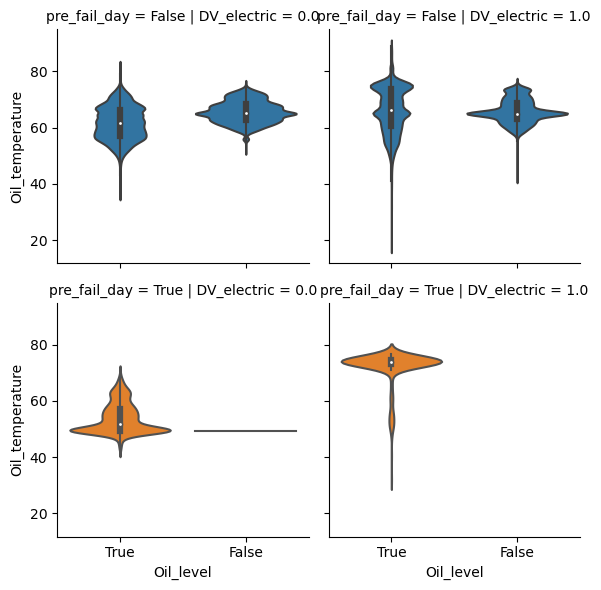

In [27]:
grid = sns.FacetGrid(metro_df_large, row='pre_fail_day', col='DV_electric', hue='pre_fail_day')
grid.map(sns.violinplot, 'Oil_level', 'Oil_temperature', order=[True, False])

In [28]:
#week_pre_fail_df = metro_df_large.loc[metro_df_large['pre_fail_week'] == 1]
#week_pre_fail_df

In [29]:
# Creating a dataframe to compare aggregate values between period leading up to a failure and period of normal operation
# ADJUST to use only pre failure period data for 'normal operation'
# RECTIFY data to consider active state of influential components. Mostly simple On/Off categories directly affecting continuous vars

data = {'near_failure_oil_temp': hour_pre_fail_df['Oil_temperature'], 'normal_oil_temp': normal_op_df['Oil_temperature']}
oil_temp_diff = pd.DataFrame(data=data)
oil_temp_diff.describe()

,near_failure_oil_temp,normal_oil_temp
count,47.000000,148699.000000
mean,65.270745,62.384442
std,7.075521,6.297531
min,49.450000,17.750000
25%,60.475000,57.675000
50%,65.175000,62.550000
75%,68.925000,66.975000
max,82.550000,82.925000


<Axes: title={'center': 'One Hour Pre-Failure vs Normal Operation: Oil Temperature'}>

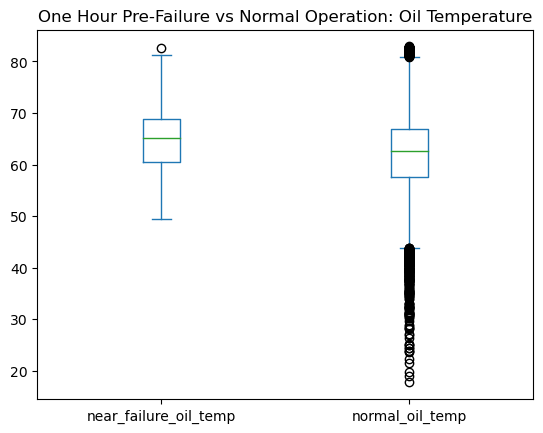

In [30]:
oil_temp_diff.plot(kind='box', title='One Hour Pre-Failure vs Normal Operation: Oil Temperature')

Text(0.5, 1.0, 'One Hour Pre-Failure vs Normal Operation: Oil Temperature')

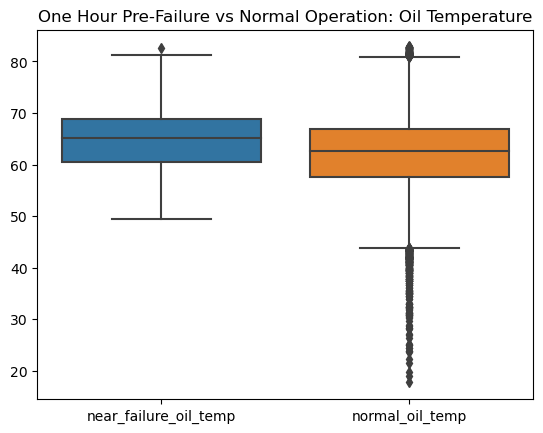

In [31]:
sns.boxplot(data=oil_temp_diff).set_title('One Hour Pre-Failure vs Normal Operation: Oil Temperature')

In [32]:
dv_data = {'near_failure_DV_pressure': hour_pre_fail_df['DV_pressure'], 'normal_DV_pressure': normal_op_df['DV_pressure']}
DV_pressure_diff = pd.DataFrame(data=dv_data)


Text(0.5, 1.0, 'One Hour Pre-Failure vs Normal Operation: DV Pressure')

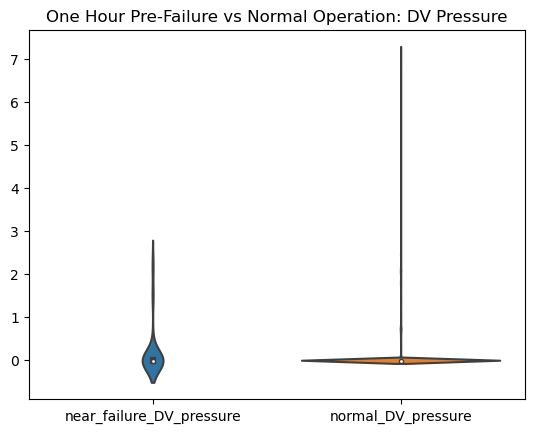

In [33]:
sns.violinplot(data=DV_pressure_diff, density_norm='count').set_title('One Hour Pre-Failure vs Normal Operation: DV Pressure')

In [34]:
print(metro_df_large.Caudal_impulses.value_counts())
print(metro_df_large.Oil_level.value_counts())

1.0    142100
0.0      9594
Name: Caudal_impulses, dtype: int64
1.0    137104
0.0     14590
Name: Oil_level, dtype: int64


# Initial Model Training + Evaluation

In [35]:
metro_df_large.columns

Index(['Unnamed: 0', 'TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current', 'COMP', 'DV_electric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses',
       'pre_fail_week', 'pre_fail_day', 'pre_fail_hour'],
      dtype='object')

In [36]:
model_df = metro_df_large[['TP2','TP3','H1','DV_pressure','Reservoirs','Oil_temperature','Motor_current','pre_fail_day']]
model_df.describe()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current
count,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000,151694.000000
mean,1.366243,8.984674,7.571054,0.056117,8.985295,62.645369,2.047747
std,3.249054,0.639051,3.330484,0.382425,0.638263,6.513671,2.301477
min,-0.032000,0.894000,-0.032000,-0.032000,0.876000,17.750000,0.020000
25%,-0.014000,8.494000,8.254000,-0.022000,8.494000,57.775000,0.040000
50%,-0.012000,8.960000,8.786000,-0.020000,8.960000,62.725000,0.045000
75%,-0.010000,9.490000,9.374000,-0.018000,9.490000,67.250000,3.807500
max,10.614000,10.262000,10.262000,7.236000,10.266000,88.950000,8.847500


In [37]:
model_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,pre_fail_day
timestamp,,,,,,,,
2020-02-01 00:01:29,-0.012,9.264,9.248,-0.022,9.264,53.375,0.04,False
2020-02-01 00:03:08,-0.012,9.162,9.146,-0.024,9.164,53.325,0.04,False
2020-02-01 00:04:47,-0.014,9.060,9.044,-0.022,9.062,53.125,0.04,False
2020-02-01 00:06:26,-0.012,8.960,8.946,-0.024,8.962,52.900,0.04,False
2020-02-01 00:08:06,-0.014,8.862,8.850,-0.024,8.866,52.650,0.04,False


In [38]:
X = model_df[['TP2','TP3','H1','DV_pressure','Reservoirs','Oil_temperature','Motor_current']]

y = model_df['pre_fail_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y.value_counts()

False    150198
True       1496
Name: pre_fail_day, dtype: int64

In [39]:
y_train.value_counts()

False    105138
True       1047
Name: pre_fail_day, dtype: int64

Accuracy: 0.9896723724977476
Precision: 0.0
Recall: 0.0
F1 Score: 0.9849944141173413


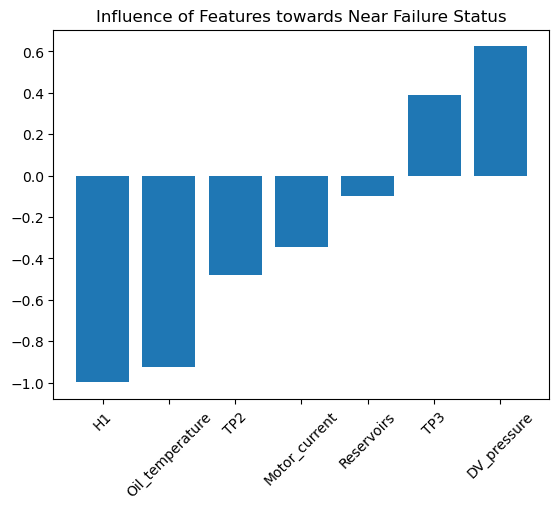

In [40]:
logreg_1 = LogisticRegression(random_state=17)

logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)

feature_importances = pd.DataFrame(data={"Feature": X.columns, "Importance": logreg_1.coef_[0]}).sort_values(by='Importance')

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
plt.bar(feature_importances["Feature"], feature_importances["Importance"])
plt.xticks(rotation=45)
plt.title("Influence of Features towards Near Failure Status")
plt.show()

# Feature Extraction

The BAR pressure value in the reservoirs ('Reservoirs') should be close to that measured at the pneumatic panel (TP3).
Next I create a dif_panel_reservoir feature by subtracting the value of 'Reservoirs' from the value of 'TP3' for each record.

In [41]:
# Creating a feature dif_panel_reservoir by subtracting Reservoirs value from TP3 value

metro_df_large['dif_panel_reservoir'] = abs(metro_df_large['TP3'] - metro_df_large['Reservoirs'])

metro_df_large['dif_panel_reservoir'].describe()

count    151694.000000
mean          0.001856
std           0.001691
min           0.000000
25%           0.000000
50%           0.002000
75%           0.002000
max           0.022000
Name: dif_panel_reservoir, dtype: float64

Creating a feature for the rolling average of the oil temperature.

In [42]:
metro_df_large['oil_rolling'] = metro_df_large['Oil_temperature'].rolling(6).mean()
metro_df_large.head(20)

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,...,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,dif_panel_reservoir,oil_rolling
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:01:29,90,-0.012,9.264,9.248,-0.022,9.264,53.375,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,NaN
2020-02-01 00:03:08,190,-0.012,9.162,9.146,-0.024,9.164,53.325,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,NaN
2020-02-01 00:04:47,290,-0.014,9.060,9.044,-0.022,9.062,53.125,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,NaN
2020-02-01 00:06:26,390,-0.012,8.960,8.946,-0.024,8.962,52.900,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,NaN
2020-02-01 00:08:06,490,-0.014,8.862,8.850,-0.024,8.866,52.650,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.004,NaN
2020-02-01 00:09:45,590,-0.012,8.768,8.754,-0.024,8.770,52.425,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,52.966667
2020-02-01 00:11:24,690,-0.014,8.676,8.662,-0.024,8.678,52.025,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,52.741667
2020-02-01 00:13:03,790,-0.014,8.584,8.570,-0.024,8.584,51.825,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,52.491667
2020-02-01 00:14:42,890,-0.014,8.494,8.480,-0.024,8.496,51.400,0.0400,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,52.204167


In [43]:
"""metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)
metro_df_clustering.info()"""

'metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)\nmetro_df_clustering.info()'

In [44]:
"""# Set up KMeans
kmeans = KMeans(n_clusters=4, n_init=10)

# Fit the model to the data
kmeans.fit(metro_df_clustering)

# Predict the clusters
metro_df_large['cluster'] = kmeans.predict(metro_df_clustering)"""

"# Set up KMeans\nkmeans = KMeans(n_clusters=4, n_init=10)\n\n# Fit the model to the data\nkmeans.fit(metro_df_clustering)\n\n# Predict the clusters\nmetro_df_large['cluster'] = kmeans.predict(metro_df_clustering)"

In [45]:
metro_df_large.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,...,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,dif_panel_reservoir,oil_rolling
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:01:29,90,-0.012,9.264,9.248,-0.022,9.264,53.375,0.04,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.000,NaN
2020-02-01 00:03:08,190,-0.012,9.162,9.146,-0.024,9.164,53.325,0.04,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,NaN
2020-02-01 00:04:47,290,-0.014,9.060,9.044,-0.022,9.062,53.125,0.04,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,NaN
2020-02-01 00:06:26,390,-0.012,8.960,8.946,-0.024,8.962,52.900,0.04,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.002,NaN
2020-02-01 00:08:06,490,-0.014,8.862,8.850,-0.024,8.866,52.650,0.04,1.0,0.0,...,1.0,0.0,1.0,1.0,1.0,False,False,False,0.004,NaN


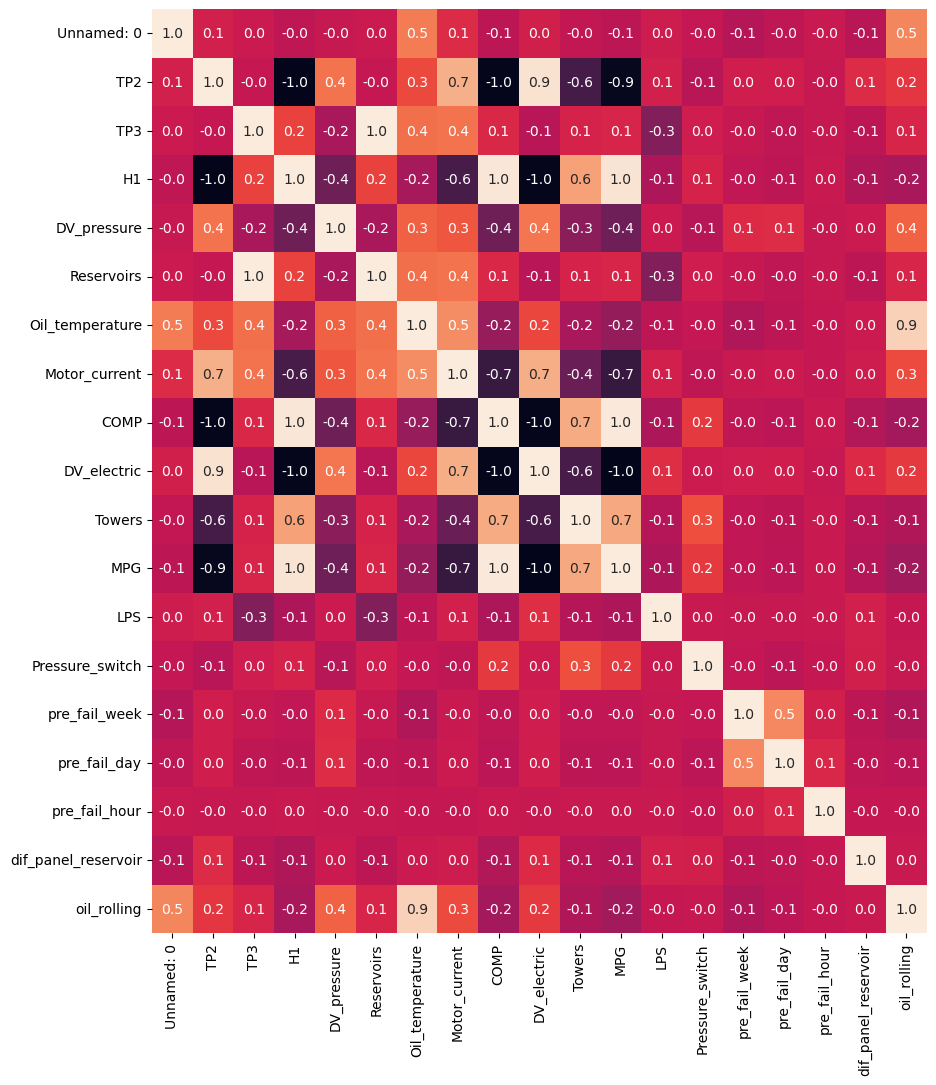

In [46]:
fig = plt.figure(figsize=(10,12))
hm = metro_df_large.drop(columns=['Oil_level','Caudal_impulses'], axis=1).corr(numeric_only=True)
sns.heatmap(hm, annot=True, fmt='.1f', cbar=False)
plt.show()

In [47]:
"""cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()
cluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()
cluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()
cluster_3_df = metro_df_large[metro_df_large.cluster == 3].copy()


cluster_0_df.head()"""


'cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()\ncluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()\ncluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()\ncluster_3_df = metro_df_large[metro_df_large.cluster == 3].copy()\n\n\ncluster_0_df.head()'

In [48]:
#cluster_0_df.describe()

In [49]:
#cluster_1_df.describe()

In [50]:
#cluster_2_df.describe()

In [51]:
# Using the pandas dataframe correlation matrix to create a heatmap of pairwise correlations
"""fig = plt.figure(figsize=(10,12))
hm = cluster_0_df.drop(columns=['Oil_level','Caudal_impulses','LPS'],axis=1).corr(numeric_only=True)
sns.heatmap(hm, annot=True, fmt='.1f', cbar=False)
plt.show()"""

"fig = plt.figure(figsize=(10,12))\nhm = cluster_0_df.drop(columns=['Oil_level','Caudal_impulses','LPS'],axis=1).corr(numeric_only=True)\nsns.heatmap(hm, annot=True, fmt='.1f', cbar=False)\nplt.show()"

Feature extraction:
* rolling averages of features
* frequency of n percentile measurements (high stress / temp / motor current)
* 